### Price prediction and classification notebook
This notebook loads data and prepares  for price prediction workflow.

In [33]:
import pandas as pd
import numpy as py

from google.colab import drive
drive.mount('/content/drive')

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/fourth/project/wfp_food_prices_eth.csv'
df = pd.read_csv(file_path)

# Access a column
print(df.shape)
print(df.columns)

# View first 5 rows
print(df.head(8))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(40482, 14)
Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')
         date       admin1                             admin2  \
0       #date   #adm1+name                         #adm2+name   
1  2000-01-15  Addis Ababa                           AA ZONE1   
2  2000-01-15  Addis Ababa                           AA ZONE1   
3  2000-01-15  Addis Ababa                           AA ZONE1   
4  2000-01-15  Addis Ababa                           AA ZONE1   
5  2000-01-15       Amhara  Administrative unit not available   
6  2000-01-15    Dire Dawa                          DIRE DAWA   
7  2000-01-15       Tigray                             MEKELE   

             market   latitude  longitude            category  \
0  #loc+m

In [34]:
import pandas as pd
import numpy as np

# Drop first row, reset index, convert date column to datetime, and cast numeric columns
df = (
    df.drop(0)
      .reset_index(drop=True)
      .assign(date=lambda x: pd.to_datetime(x['date']))
      .astype({'price': float, 'usdprice': float})
)

# Sort by date, drop duplicates, reset index
df = df.sort_values('date').drop_duplicates().reset_index(drop=True)

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Clean commodity column: remove parentheses text and extract variety
df['commodity_base'] = df['commodity'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
df['variety'] = df['commodity'].str.extract(r'\((.*?)\)', expand=False).fillna('')

# Check missing values
print(df.isnull().sum())

# Replace unavailable admin2 values with NaN
df['admin2'] = df['admin2'].replace('Administrative unit not available', np.nan)

# Convert latitude and longitude to numeric
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].apply(pd.to_numeric, errors='coerce')

# Keep only rows with positive price
df = df[df['price'] > 0].reset_index(drop=True)

# Convert categorical columns
df[['admin1', 'admin2', 'market', 'pricetype', 'category']] = df[['admin1', 'admin2', 'market', 'pricetype', 'category']].astype('category')

# Handle missing admin2 values
df['admin2'] = df['admin2'].cat.add_categories('Unknown').fillna('Unknown')

# Drop rows with missing admin1, latitude, longitude
df = df.dropna(subset=['admin1', 'latitude', 'longitude']).reset_index(drop=True)

# Replace empty variety with 'Standard'
df['variety'] = df['variety'].replace('', 'Standard').fillna('Standard')

# Clean unit column
df['unit'] = df['unit'].str.strip().str.upper()

# Drop unnecessary columns
df = df.drop(columns=['commodity','priceflag','currency'])

# Final checks
print(df.shape)
print(df.tail())
print(df.head())

date              0
admin1            5
admin2            5
market            0
latitude          5
longitude         5
category          0
commodity         0
unit              0
priceflag         0
pricetype         0
currency          0
price             0
usdprice          0
year              0
month             0
commodity_base    0
variety           0
dtype: int64
(40476, 15)
            date   admin1  admin2             market  latitude  longitude  \
40471 2023-12-15  Gambela  ZONE 3  Kowerneng/Korgang  8.326659  33.953408   
40472 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40473 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40474 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40475 2023-12-15   Somali    GODE               Gode  6.022500  43.130278   

                  category    unit pricetype    price  usdprice  year  month  \
40471   cereals and tubers  100 KG    Retail   4500.0   80.7609  2023   

Total Outliers Detected: 298


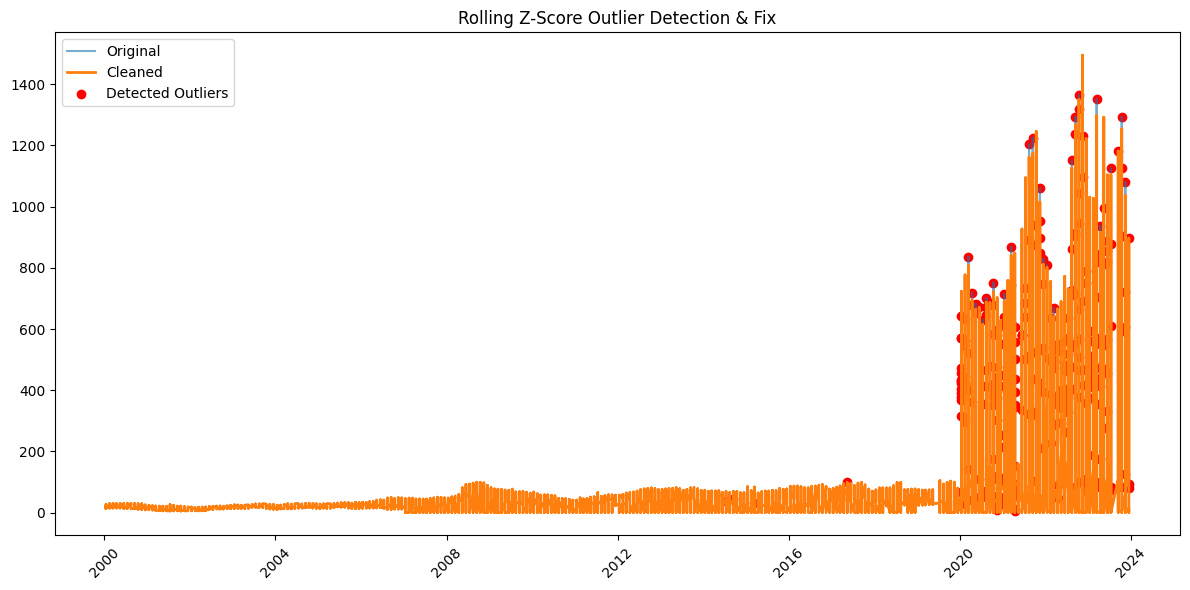

In [37]:
# ============================================================
# BEST TIME SERIES OUTLIER DETECTION + FIX
# Rolling Z-Score + Dynamic Winsorization
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1️⃣ SORT BY TIME (VERY IMPORTANT)
# ------------------------------------------------------------
df = df.sort_values('date').reset_index(drop=True)

# ------------------------------------------------------------
# 2️⃣ SET PARAMETERS
# ------------------------------------------------------------
window = 12   # 12 months rolling window (change to 6 if needed)
z_threshold = 3

# ------------------------------------------------------------
# 3️⃣ CALCULATE ROLLING STATISTICS
# ------------------------------------------------------------
df['rolling_mean'] = df['usdprice'].rolling(window).mean()
df['rolling_std'] = df['usdprice'].rolling(window).std()

# Rolling Z-score
df['z_score'] = (df['usdprice'] - df['rolling_mean']) / df['rolling_std']

# ------------------------------------------------------------
# 4️⃣ DETECT OUTLIERS
# ------------------------------------------------------------
df['is_outlier'] = df['z_score'].abs() > z_threshold

print("Total Outliers Detected:", df['is_outlier'].sum())

# ------------------------------------------------------------
# 5️⃣ FIX OUTLIERS (Dynamic Rolling Cap)
# ------------------------------------------------------------
upper_bound = df['rolling_mean'] + z_threshold * df['rolling_std']
lower_bound = df['rolling_mean'] - z_threshold * df['rolling_std']

df['usdprice_cleaned'] = df['usdprice'].copy()

df.loc[df['usdprice'] > upper_bound, 'usdprice_cleaned'] = upper_bound
df.loc[df['usdprice'] < lower_bound, 'usdprice_cleaned'] = lower_bound

# ------------------------------------------------------------
# 6️⃣ VISUALIZE BEFORE & AFTER
# ------------------------------------------------------------
plt.figure(figsize=(12,6))

plt.plot(df['date'], df['usdprice'], label='Original', alpha=0.6)
plt.plot(df['date'], df['usdprice_cleaned'], label='Cleaned', linewidth=2)

plt.scatter(
    df.loc[df['is_outlier'], 'date'],
    df.loc[df['is_outlier'], 'usdprice'],
    color='red',
    label='Detected Outliers'
)

plt.legend()
plt.title("Rolling Z-Score Outlier Detection & Fix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              40476 non-null  datetime64[ns]
 1   admin1            40476 non-null  category      
 2   admin2            40476 non-null  category      
 3   market            40476 non-null  category      
 4   latitude          40476 non-null  float64       
 5   longitude         40476 non-null  float64       
 6   category          40476 non-null  category      
 7   unit              40476 non-null  object        
 8   pricetype         40476 non-null  category      
 9   price             40476 non-null  float64       
 10  usdprice          40476 non-null  float64       
 11  year              40476 non-null  int32         
 12  month             40476 non-null  int32         
 13  commodity_base    40476 non-null  object        
 14  variety           4047

In [39]:
encoding_cols = [
    'admin1','admin2','market',
    'category','pricetype',
    'unit','commodity_base','variety'
]

# Show unique counts and sample categories
for col in encoding_cols:
    print(f"\nColumn: {col}")
    print(f"Unique count: {df[col].nunique()}")
    print(f"Categories: {df[col].unique()[:10]}")  # show first 10 unique values


Column: admin1
Unique count: 11
Categories: ['Addis Ababa', 'Amhara', 'Dire Dawa', 'Tigray', 'Oromia', 'SNNPR', 'Somali', 'Afar', 'Gambela', 'B. Gumuz']
Categories (11, object): ['Addis Ababa', 'Afar', 'Amhara', 'B. Gumuz', ..., 'Oromia', 'SNNPR', 'Somali',
                          'Tigray']

Column: admin2
Unique count: 59
Categories: ['AA ZONE1', 'Unknown', 'DIRE DAWA', 'MEKELE', 'BALE', 'N. GONDER', 'ARSI', 'S. WELLO', 'HADIYA', 'E. SHEWA']
Categories (59, object): ['AA ZONE1', 'AFDER', 'ALABA SW', 'AMARO SW', ..., 'ZONE3', 'ZONE4', 'ZONE5',
                          'Unknown']

Column: market
Unique count: 118
Categories: ['Addis Ababa', 'Baher Dar', 'Diredawa', 'Mekele', 'Robe', 'Gonder', 'Assela', 'Dessie', 'Hossana', 'Nazareth']
Categories (119, object): ['Abaala', 'Abi Adi', 'Abomsa', 'Addis Ababa', ..., 'Wonago', 'Wukro',
                           'Yabelo', 'Ziway']

Column: category
Unique count: 8
Categories: ['cereals and tubers', 'pulses and nuts', 'milk and dairy', 'mi

In [26]:
print(df.columns)
print(df.info())
df.describe()

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'unit', 'pricetype', 'price', 'usdprice', 'year', 'month',
       'commodity_base', 'variety'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            40476 non-null  datetime64[ns]
 1   admin1          40476 non-null  category      
 2   admin2          40476 non-null  category      
 3   market          40476 non-null  category      
 4   latitude        40476 non-null  float64       
 5   longitude       40476 non-null  float64       
 6   category        40476 non-null  category      
 7   unit            40476 non-null  object        
 8   pricetype       40476 non-null  category      
 9   price           40476 non-null  float64       
 10  usdprice        40476 non-null  float64       
 11  yea

,date,latitude,longitude,price,usdprice,year,month
count,40476,40476.000000,40476.000000,40476.000000,40476.000000,40476.000000,40476.000000
mean,2018-09-22 21:15:27.482952960,9.490376,39.626584,2533.982040,59.247781,2018.244688,6.333185
min,2000-01-15 00:00:00,3.534996,33.953408,0.880000,0.091600,2000.000000,1.000000
25%,2015-01-15 00:00:00,7.666667,38.420666,94.000000,2.071175,2015.000000,3.000000
50%,2020-11-15 00:00:00,9.313870,39.544560,800.000000,37.239250,2020.000000,6.000000
75%,2022-06-15 00:00:00,11.340700,41.416665,3400.000000,74.992500,2022.000000,9.000000
max,2023-12-15 00:00:00,14.454050,44.279701,79000.000000,1495.079500,2023.000000,12.000000
std,NaN,2.502090,1.956364,4729.544242,94.791431,5.153325,3.467811


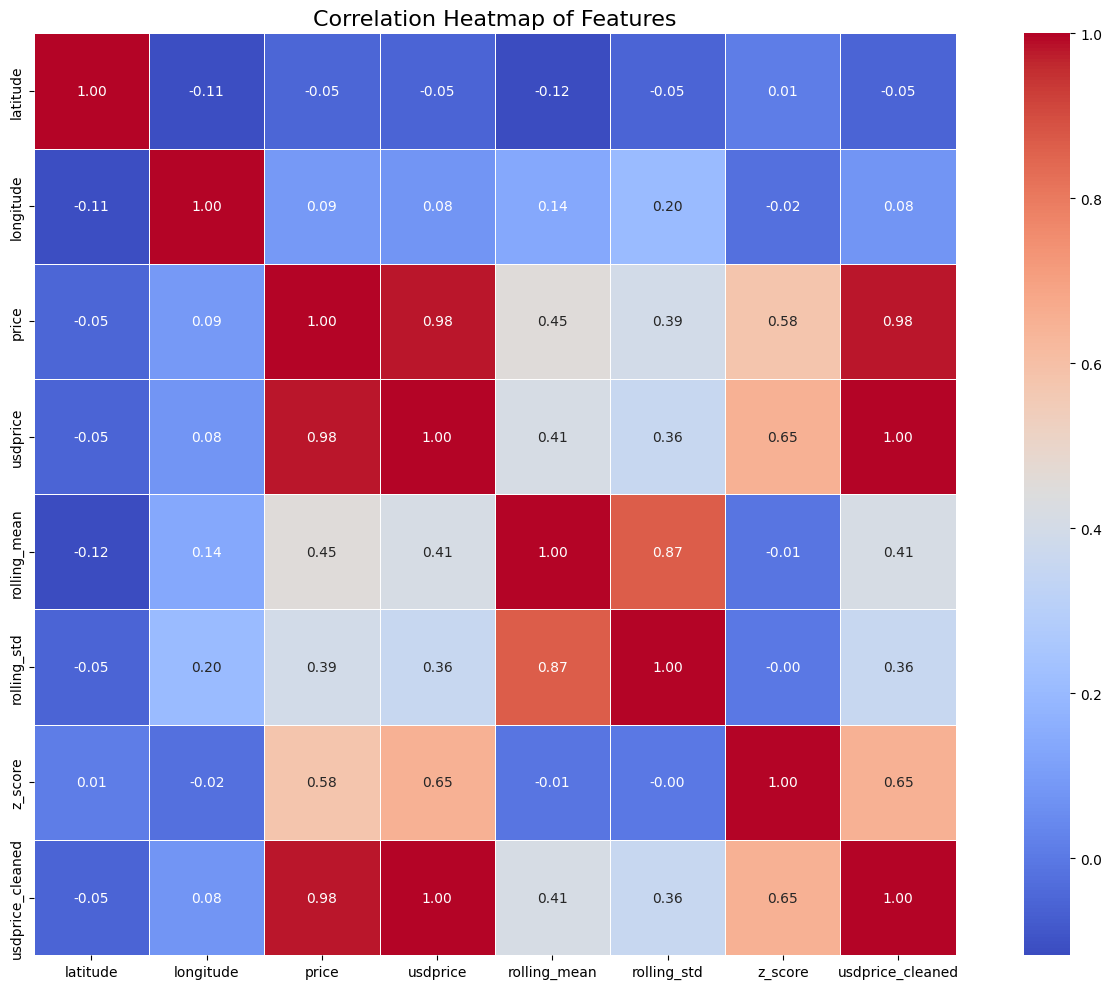

In [40]:

# ============================================================
# CORRELATION HEATMAP
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Use only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64','float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14,10))

# Draw the heatmap with annotations
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal points
    cmap='coolwarm',   # color map
    cbar=True,
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.tight_layout()
plt.show()

In [41]:
# inplace
df.drop(['price','usdprice'], axis=1, inplace=True)

In [42]:
# ============================================================
# FULL DATA PREPROCESSING PIPELINE (ML READY)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ CLEAN & STANDARDIZE UNITS
# -----------------------------
df['unit'] = df['unit'].astype(str).str.strip().str.upper()

# Convert bulk to per KG (optional but recommended)
df.loc[df['unit']=='100 KG','usdprice_cleaned'] /= 100
df['unit'] = df['unit'].replace('100 KG','KG')

# -----------------------------
# 2️⃣ CLEAN & FIX PRICETYPE
# -----------------------------
df['pricetype'] = df['pricetype'].astype(str).str.strip().str.lower()

# Map to numeric safely using map (avoids FutureWarning)
pricetype_map = {'retail': 0, 'wholesale': 1, '0': 0, '1': 1}
df['pricetype'] = df['pricetype'].map(pricetype_map)

# Fill any remaining NaNs with mode
df['pricetype'] = df['pricetype'].fillna(df['pricetype'].mode()[0]).astype(int)

# -----------------------------
# 3️⃣ CLEAN & CONVERT OTHER CATEGORICALS
# -----------------------------
cat_cols = ['admin1','admin2','market','category']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().replace('', 'Unknown').astype('category')

# -----------------------------
# 4️⃣ ONE-HOT ENCODING (LOW CARDINALITY)
# -----------------------------
if 'category' in df.columns:
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

# -----------------------------
# 5️⃣ LABEL ENCODING (HIGH CARDINALITY)
# -----------------------------
label_cols = ['market','unit','commodity_base','variety']
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# -----------------------------
# 6️⃣ FINAL CHECK
# -----------------------------
print("✅ Preprocessing Complete")
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSample Data:")
print(df.head())

# -----------------------------
# 7️⃣ CORRELATION HEATMAP
# -----------------------------
numeric_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

KeyError: 'usdprice'

In [29]:
# ============================================================
# MULTI-MODEL PIPELINE WITH K-FOLD TARGET ENCODING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

# ------------------------------------------------------------
# 1️⃣ TIME-BASED SPLIT
# ------------------------------------------------------------
train = df[df['year'] <= 2021].copy()
test = df[df['year'] > 2021].copy()

# ------------------------------------------------------------
# 2️⃣ K-FOLD TARGET ENCODING FUNCTION
# ------------------------------------------------------------
def kfold_target_encoding(train_df, test_df, column, target, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    train_encoded = pd.Series(index=train_df.index, dtype=float)

    global_mean = train_df[target].mean()

    for train_idx, val_idx in kf.split(train_df):

        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]

        means = fold_train.groupby(column)[target].mean()

        train_encoded.iloc[val_idx] = fold_val[column].map(means)

    train_encoded.fillna(global_mean, inplace=True)

    # Encode test using full training data
    full_means = train_df.groupby(column)[target].mean()
    test_encoded = test_df[column].map(full_means)
    test_encoded.fillna(global_mean, inplace=True)

    return train_encoded, test_encoded

# ------------------------------------------------------------
# 3️⃣ APPLY TARGET ENCODING TO admin1 & admin2
# ------------------------------------------------------------
for col in ['admin1', 'admin2']:
    train[col + '_te'], test[col + '_te'] = kfold_target_encoding(
        train, test, column=col, target='usdprice'
    )

# Drop original categorical columns
train.drop(columns=['admin1','admin2'], inplace=True)
test.drop(columns=['admin1','admin2'], inplace=True)

# ------------------------------------------------------------
# 4️⃣ DEFINE FEATURES & TARGET
# ------------------------------------------------------------
X_train = train.drop(columns=['usdprice','price','date'])
y_train = train['usdprice']

X_test = test.drop(columns=['usdprice','price','date'])
y_test = test['usdprice']

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# ------------------------------------------------------------
# 5️⃣ INITIALIZE MODELS
# ------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Extra Trees": ExtraTreesRegressor(n_estimators=120, random_state=42, n_jobs=-1)
}

results = []

# ------------------------------------------------------------
# 6️⃣ TRAIN & EVALUATE
# ------------------------------------------------------------
for name, model in models.items():

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

    print(f"\n{name}")
    print("MAE :", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("R²  :", round(r2,3))

# ------------------------------------------------------------
# 7️⃣ RESULTS TABLE
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','R2'])
print("\nMODEL COMPARISON")
print(results_df.sort_values('R2', ascending=False))

# ------------------------------------------------------------
# 8️⃣ FEATURE IMPORTANCE (BEST TREE MODEL)
# ------------------------------------------------------------
best_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importance.head(12).plot(kind='bar')

plt.title("Top 12 Important Features (Target Encoding)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-190/2566321036.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = fold_train.groupby(column)[target].mean()


AssertionError: Something has gone wrong, please report a bug at https://github.com/pandas-dev/pandas/issues


--- Random Forest ---
Accuracy: 0.9401, F1-score: 0.8810
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      6169
           1       0.84      0.93      0.88      1927

    accuracy                           0.94      8096
   macro avg       0.91      0.94      0.92      8096
weighted avg       0.94      0.94      0.94      8096


--- XGBoost ---
Accuracy: 0.9545, F1-score: 0.9043
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6169
           1       0.91      0.90      0.90      1927

    accuracy                           0.95      8096
   macro avg       0.94      0.94      0.94      8096
weighted avg       0.95      0.95      0.95      8096


--- Gradient Boosting ---
Accuracy: 0.9500, F1-score: 0.8938
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      6169
           1       0.90      0.88      0.89      1927

    accura

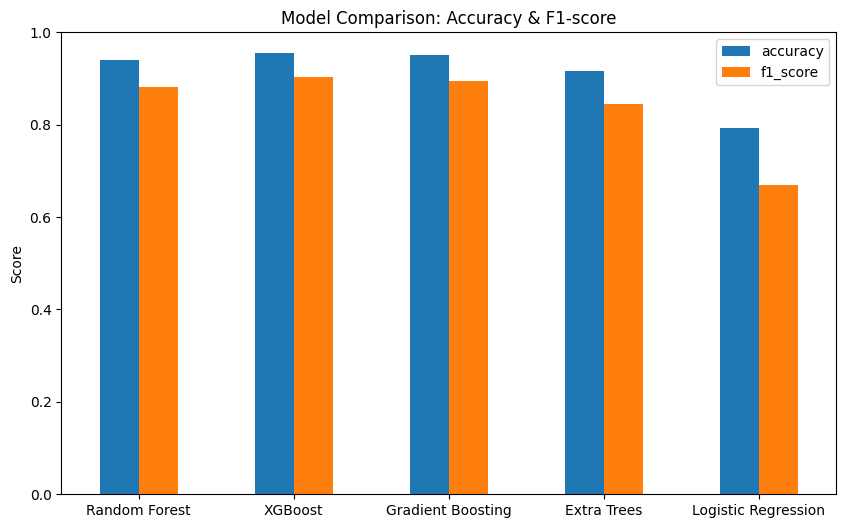

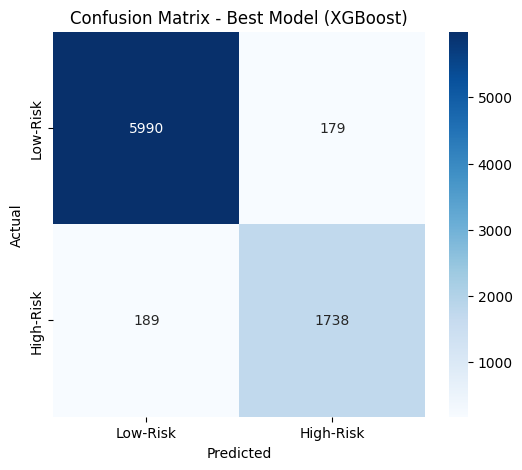

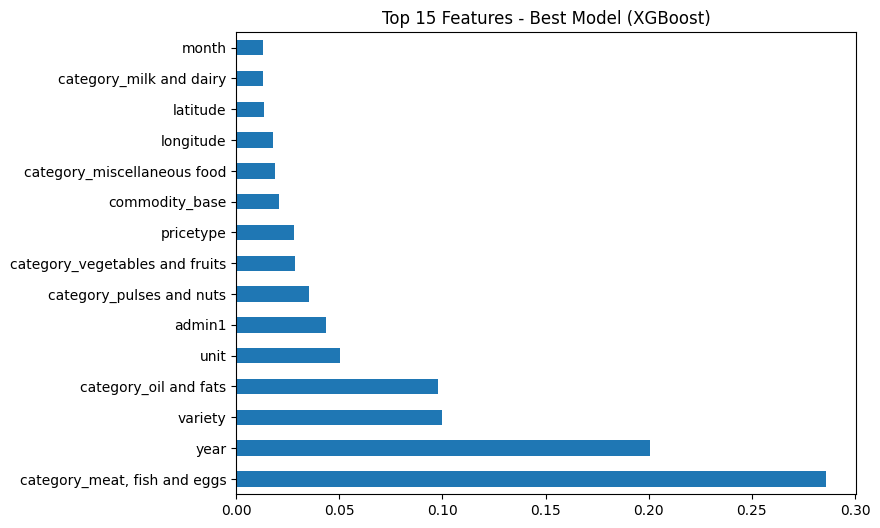

✅ Best Model: XGBoost with F1-score = 0.9043


/tmp/ipython-input-148/1569530968.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['admin1','early_warning_level']).size().unstack(fill_value=0)



========== EARLY WARNING DISTRIBUTION BY REGION ==========
early_warning_level  Low Risk  Moderate Risk  Severe Risk
admin1                                                   
0                        1948              0            0
1                         464            316          189
2                        5927           2435          600
3                         473              0            0
4                        1425            347            3
5                         831            219            0
6                         548            136            0
7                       10888           1028           25
8                        3141              1            0
9                         318           1786         2800
10                       2370           1827          431


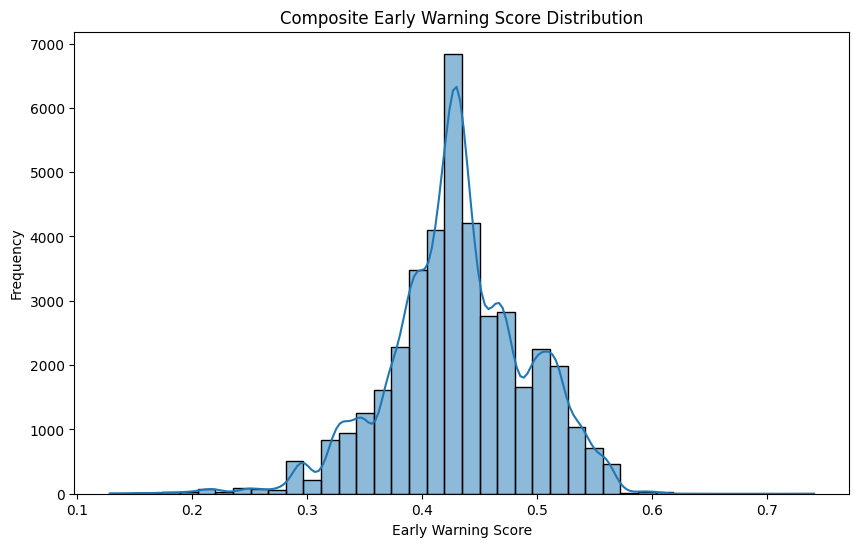

Top High-Risk Foods:
 commodity_base
24    7204
49    5848
41    4705
23    4574
46    2554
3     1802
48    1066
35     876
34     812
27     792
Name: count, dtype: int64
Top High-Risk Regions:
 admin1  admin2
7       11        3110
        47        2120
9       23        2004
0       0         1948
7       12        1928
4       9         1734
2       39        1502
9       17        1450
7       6         1283
10      8         1222
dtype: int64


In [ ]:
# ===============================================================
# FOOD CRISIS RISK CLASSIFICATION & EARLY WARNING SYSTEM
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# =========================
# 1️⃣ Prepare Target
# =========================
# Assume df is already loaded with your food dataset
df['high_risk'] = df.groupby('commodity_base')['price'].transform(
    lambda x: x > x.quantile(0.75)
).astype(int)

# Identify all columns that should NOT be features for the model
columns_to_exclude = ['usdprice', 'price', 'date', 'high_risk']

# Check if 'early_warning_level' exists in df (from previous runs) and exclude it
if 'early_warning_level' in df.columns:
    columns_to_exclude.append('early_warning_level')

# Define features (X) by dropping excluded columns
X = df.drop(columns=columns_to_exclude, errors='ignore') # Use errors='ignore' for robustness
y = df['high_risk']

# =========================
# 2️⃣ Train/Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 3️⃣ Preprocessing
# =========================
# Only numeric columns for scaling
num_cols = ['latitude','longitude','year','month','unit','pricetype','commodity_base','variety']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# =========================
# 4️⃣ Define Models
# =========================
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=200, max_depth=6, random_state=42, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
}

results = {}
best_model_name = None
best_f1 = 0

# =========================
# 5️⃣ Train, Predict & Evaluate All Models
# =========================
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'accuracy': acc, 'f1_score': f1, 'model': model, 'y_pred': y_pred}

    print(f"\n--- {name} ---")
    print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

# =========================
# 6️⃣ Compare Models Visually
# =========================
comparison_df = pd.DataFrame(results).T[['accuracy','f1_score']]
comparison_df.plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison: Accuracy & F1-score")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

# =========================
# 7️⃣ Best Model Analysis
# =========================
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['y_pred']

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low-Risk','High-Risk'], yticklabels=['Low-Risk','High-Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_model_name})')
plt.show()

if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting', 'Extra Trees']:
    feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top_features = feat_importances.nlargest(15)
    plt.figure(figsize=(8,6))
    top_features.plot(kind='barh')
    plt.title(f"Top 15 Features - Best Model ({best_model_name})")
    plt.show()

print(f"✅ Best Model: {best_model_name} with F1-score = {best_f1:.4f}")

# =========================
# 8️⃣ Predict High-Risk Instances
# =========================
df['predicted_risk'] = best_model.predict(X)
df['ml_probability'] = best_model.predict_proba(X)[:,1]

# =========================
# 9️⃣ Add Structural & Shock Risks
# =========================
# Drop old columns if they exist
for col in ['inequality_index','inflation_shock_index','ml_norm','early_warning_score']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Structural Risk → Inequality Index
region_avg = df.groupby(['admin1','commodity_base'])['price'].mean().reset_index()
national_avg = df.groupby('commodity_base')['price'].mean().reset_index()
national_avg.rename(columns={'price':'national_avg'}, inplace=True)
region_avg = region_avg.merge(national_avg, on='commodity_base')
region_avg['price_ratio'] = region_avg['price'] / region_avg['national_avg']

volatility = df.groupby('admin1')['price'].agg(['mean','std']).reset_index()
volatility['cv'] = volatility['std'] / volatility['mean']

inequality = region_avg.merge(volatility[['admin1','cv']], on='admin1')
inequality['ratio_norm'] = (inequality['price_ratio'] - inequality['price_ratio'].min()) / (inequality['price_ratio'].max() - inequality['price_ratio'].min() + 1e-9)
inequality['cv_norm'] = (inequality['cv'] - inequality['cv'].min()) / (inequality['cv'].max() - inequality['cv'].min() + 1e-9)
inequality['inequality_index'] = 0.6*inequality['ratio_norm'] + 0.4*inequality['cv_norm']

df = df.merge(
    inequality[['admin1','commodity_base','inequality_index']],
    on=['admin1','commodity_base'],
    how='left'
)
df['inequality_index'] = df['inequality_index'].fillna(df['inequality_index'].mean())

# Shock Risk → Inflation Shock Index
df = df.sort_values(['commodity_base','date'])
df['inflation'] = df.groupby('commodity_base')['price'].pct_change()*100
df['infl_vol'] = df.groupby('commodity_base')['inflation'].rolling(3).std().reset_index(0,drop=True)
df['infl_norm'] = (df['inflation'] - df['inflation'].min()) / (df['inflation'].max() - df['inflation'].min() + 1e-9)
df['infl_vol_norm'] = (df['infl_vol'] - df['infl_vol'].min()) / (df['infl_vol'].max() - df['infl_vol'].min() + 1e-9)
df['inflation_shock_index'] = 0.7*df['infl_norm'].fillna(0) + 0.3*df['infl_vol_norm'].fillna(0)

# Predictive Risk → ML probability normalized
df['ml_norm'] = (df['ml_probability'] - df['ml_probability'].min()) / \
                (df['ml_probability'].max() - df['ml_probability'].min() + 1e-9)

# Final Risk → Composite Early Warning Score
df['early_warning_score'] = 0.4*df['inequality_index'] + \
                            0.3*df['inflation_shock_index'] + \
                            0.3*df['ml_norm']

# Keep categorical labels, avoid converting to float
df['early_warning_level'] = pd.qcut(
    df['early_warning_score'],
    q=[0,0.7,0.9,1],
    labels=['Low Risk','Moderate Risk','Severe Risk']
)

# =========================
# 10️⃣ Output Summary
# =========================
summary = df.groupby(['admin1','early_warning_level']).size().unstack(fill_value=0)
print("\n========== EARLY WARNING DISTRIBUTION BY REGION ==========")
print(summary)

plt.figure(figsize=(10,6))
sns.histplot(df['early_warning_score'], bins=40, kde=True)
plt.title("Composite Early Warning Score Distribution")
plt.xlabel("Early Warning Score")
plt.ylabel("Frequency")
plt.show()

# =========================
# 11️⃣ Top High-Risk Foods & Regions
# =========================
high_risk_foods = df[df['predicted_risk']==1]['commodity_base'].value_counts()
print("Top High-Risk Foods:\n", high_risk_foods.head(10))

high_risk_regions = df[df['predicted_risk']==1].groupby(['admin1','admin2']).size().sort_values(ascending=False)
print("Top High-Risk Regions:\n", high_risk_regions.head(10))

In [ ]:
import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup
import branca.colormap as cm
import numpy as np

# -----------------------------
# 1️⃣ Define risk bins & colors
# -----------------------------
risk_bins = [0, 0.3, 0.5, 0.7, 0.85, 1]
risk_colors = ['green','lime','yellow','orange','red']

def get_risk_color(score):
    """Assign color based on composite early warning score."""
    for i, upper in enumerate(risk_bins[1:]):
        if score <= upper:
            return risk_colors[i]
    return risk_colors[-1]

# -----------------------------
# 2️⃣ Create main map
# -----------------------------
m = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=6,
    tiles='CartoDB positron',
    control_scale=True
)

# -----------------------------
# 3️⃣ Create marker cluster
# -----------------------------
marker_cluster = MarkerCluster(name='All Markets').add_to(m)

# -----------------------------
# 4️⃣ Create subgroups per commodity
# -----------------------------
commodities = df['commodity_base'].unique()
commodity_groups = {}
for comm in commodities:
    fg = FeatureGroupSubGroup(marker_cluster, name=str(comm))
    commodity_groups[comm] = fg
    m.add_child(fg)

# -----------------------------
# 5️⃣ Add markers with full info
# -----------------------------
for _, row in df.iterrows():
    color = get_risk_color(row['early_warning_score'])

    # Format popup content with actual categorical names
    popup_content = f"""
    <div style="font-family: Arial; font-size: 12px;">
        <b>Commodity:</b> {row['commodity_base']} ({row['variety']})<br>
        <b>Market:</b> {row['market']}<br>
        <b>Region:</b> {row['admin1']} / {row['admin2']}<br>
        <b>Price:</b> ${row['usdprice']:.2f}<br>
        <b>Structural Risk:</b> {row['inequality_index']:.3f}<br>
        <b>Shock Risk:</b> {row['inflation_shock_index']:.3f}<br>
        <b>Predictive Risk:</b> {row['ml_norm']:.3f}<br>
        <b>Composite Score:</b> {row['early_warning_score']:.3f}<br>
        <b>Early Warning Level:</b> {row['early_warning_level']}
    </div>
    """

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=min(3 + row['usdprice']/5, 15),  # cap marker size for clarity
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"{row['commodity_base']} - ${row['usdprice']:.2f}",
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(commodity_groups[row['commodity_base']])

# -----------------------------
# 6️⃣ Add risk legend
# -----------------------------
colormap = cm.StepColormap(
    colors=risk_colors,
    index=risk_bins,
    vmin=0,
    vmax=1,
    caption='Composite Early Warning Score'
)
colormap.add_to(m)

# -----------------------------
# 7️⃣ Add layer control
# -----------------------------
folium.LayerControl(collapsed=False).add_to(m)

# -----------------------------
# 8️⃣ Display map
# -----------------------------
m